In [2]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSTyupJYW8-dOI7rTKOVE-bMT4M_8UnVnRLOJGavyVh33-4wHTkP4Q-uWX9mwMQul2kxMl8aJLR0FHB/pub?output=csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [4]:


named_data <- data %>%
    rename(
        monday = weekday_is_monday,
        tuesday = weekday_is_tuesday,
        wednesday = weekday_is_wednesday,
        thursday = weekday_is_thursday,
        friday = weekday_is_friday,
        saturday = weekday_is_saturday,
        sunday = weekday_is_sunday,
        lifestyle = data_channel_is_lifestyle,
        entertainment =  data_channel_is_entertainment,
        business = data_channel_is_bus,
        social_media =  data_channel_is_socmed,
        technology =  data_channel_is_tech,
        world =  data_channel_is_world
    )


Genre,Day_Of_Week,shares,abs_pos,abs_neg,title_subjectivity
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
entertainment,monday,593,0.01728933,0.004794521,0.5000000
business,monday,711,0.01237671,0.001862745,0.0000000
business,monday,1500,0.02819905,0.004423381,0.0000000
entertainment,monday,1200,0.01599102,0.007658506,0.0000000
technology,monday,505,0.03068115,0.002670243,0.4545455
technology,monday,855,0.01042354,0.005270270,0.6428571


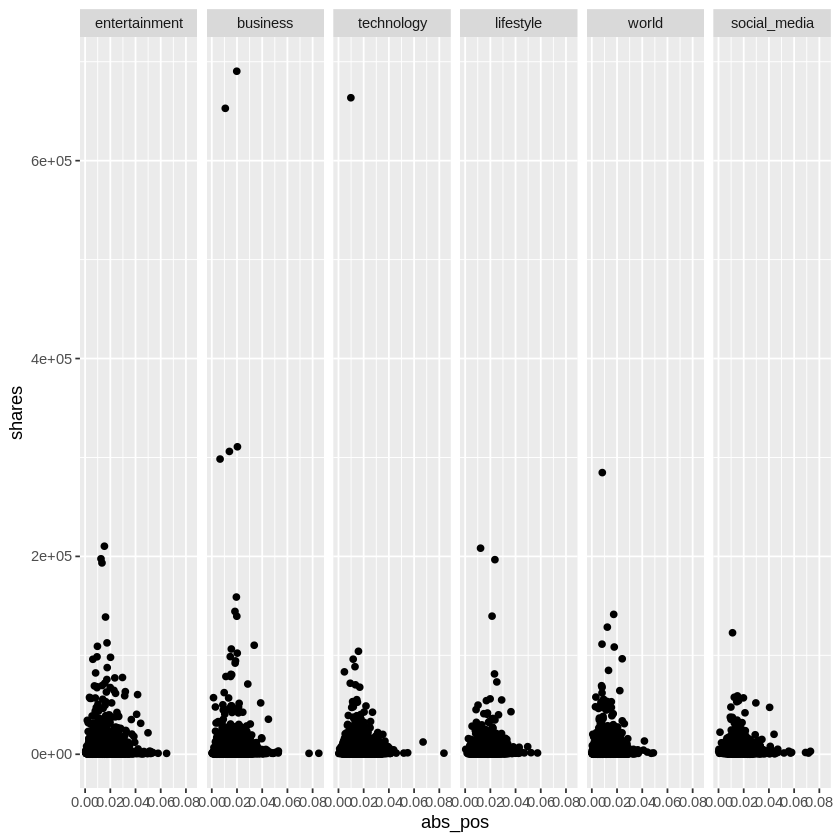

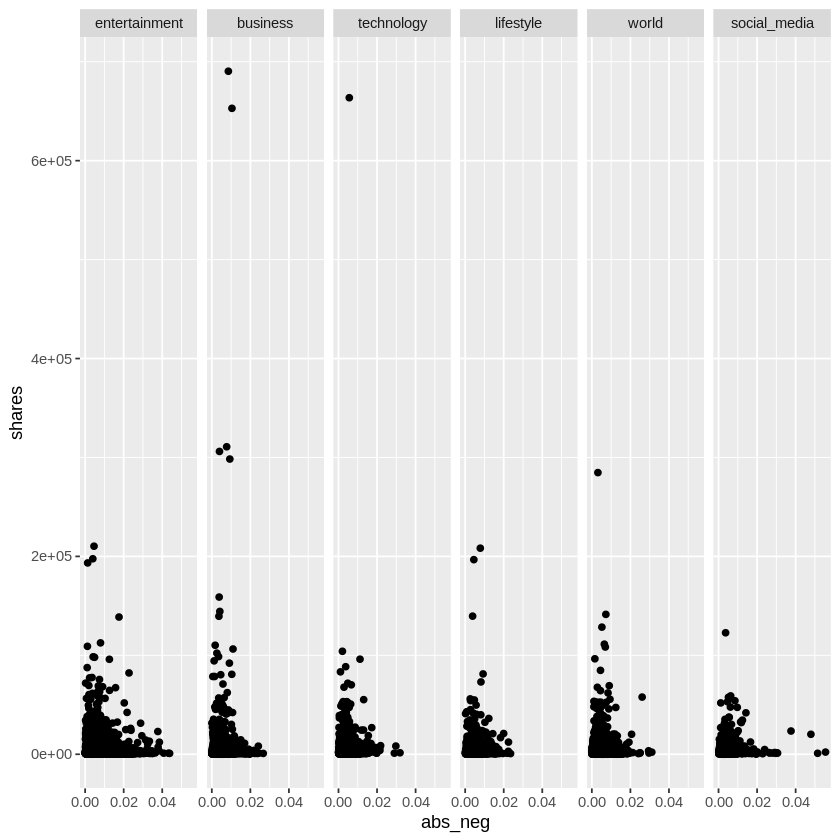

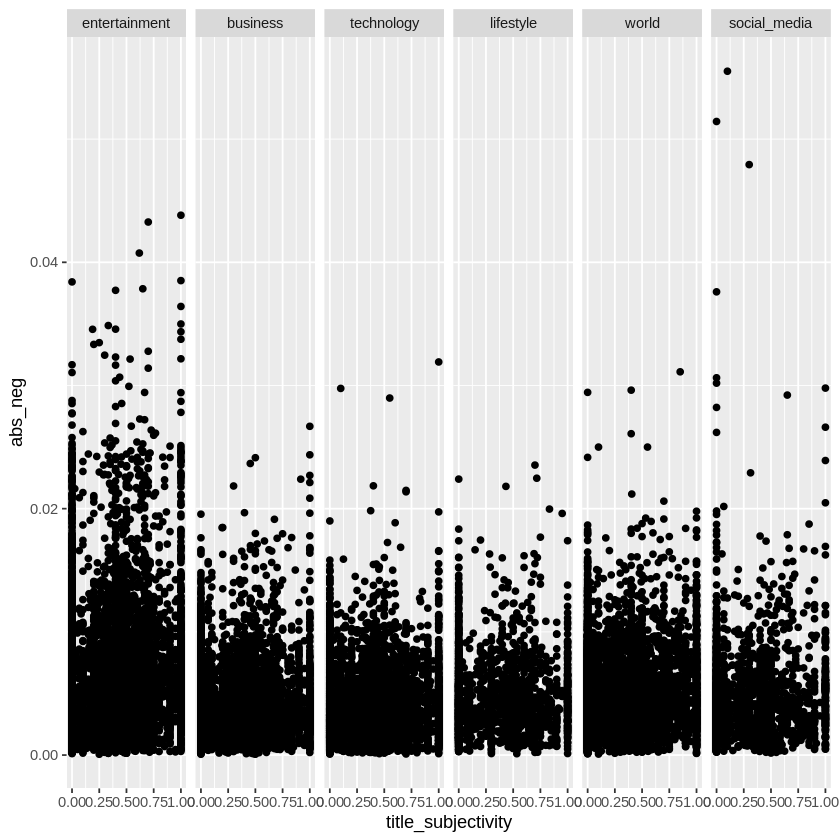

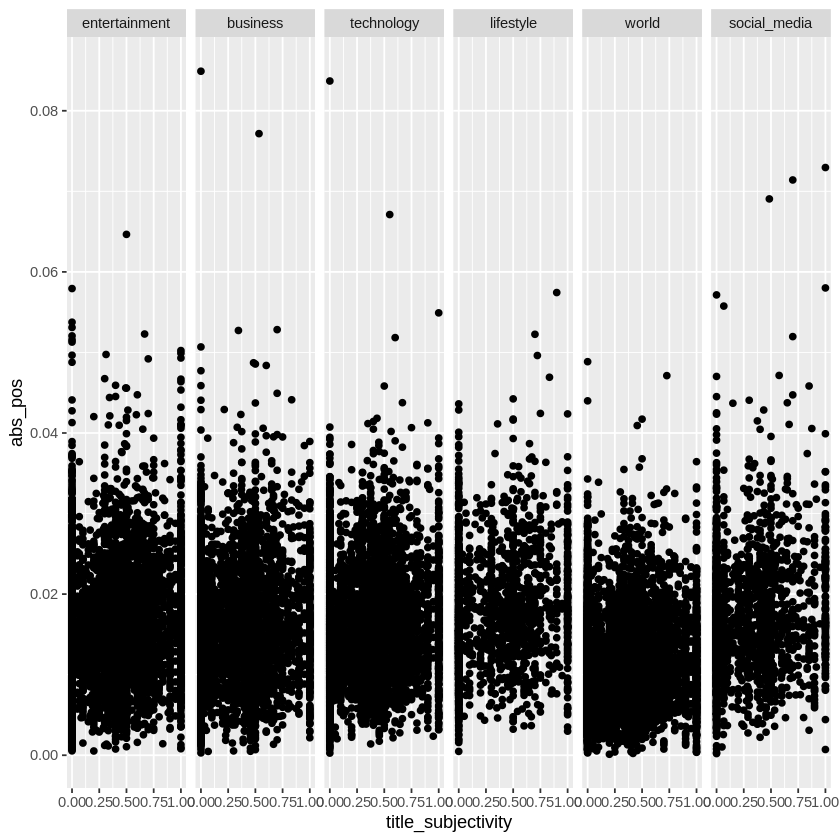

In [5]:
#It didn't work when all in one pipe, I have no idea why. This seems to work though
tidy_data <- named_data %>%
    pivot_longer(cols =  lifestyle:world, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    filter(Genre_Present == 1) %>%
    pivot_longer(cols =   monday:sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Day_Present == 1) %>%
    filter(global_rate_positive_words != 0 & global_rate_negative_words != 0) %>%
    mutate(abs_pos = (global_rate_positive_words*avg_positive_polarity)) %>%
    mutate(abs_neg = (abs(global_rate_negative_words*avg_negative_polarity))) %>%
    mutate(Genre = as_factor(Genre)) %>%
    mutate(Day_Of_Week = as_factor(Day_Of_Week)) %>%
    select(Genre, Day_Of_Week, shares, abs_pos, abs_neg, title_subjectivity)

head(tidy_data)

share_plot <- ggplot(tidy_data, aes(x = abs_pos, y = shares))+
            geom_point()+
              facet_grid( ~ Genre)

share_plot2 <- ggplot(tidy_data, aes(x = abs_neg, y = shares))+
            geom_point()+
          facet_grid( ~ Genre)

share_plot3 <- ggplot(tidy_data, aes(x = title_subjectivity, y = abs_neg))+
            geom_point()+
          facet_grid( ~ Genre)
share_plot4 <- ggplot(tidy_data, aes(x = title_subjectivity, y = abs_pos))+
            geom_point()+
          facet_grid( ~ Genre)

share_plot
share_plot2
share_plot3
share_plot4

In [17]:
set.seed(1234)
publishing_split <- initial_split(tidy_data, prop = 0.75, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

head(publishing_train)

day_table <- publishing_train %>%
    group_by(Day_Of_Week) %>%
    summarize(total_articles=n(), avg_shares=mean(shares),abs_pos = mean(abs_pos),avg_shares=mean(shares),abs_neg = mean(abs_neg))
day_table
#grouped by the day of the week so we can summarize the total amount of articles of that day of the week, the average shares of that day of the week, and the positive to negative word ratio of that day of the week

genre_table <- publishing_train %>%
    group_by(Genre) %>%
    summarize(total_articles=n(), avg_shares=mean(shares),abs_pos = mean(abs_pos),avg_shares=mean(shares),abs_neg = mean(abs_neg) )
genre_table
#grouped by the genre so we can summarize the total articles from that genre, the average shares of that genre and the positive to negative word ratio of that genre

Genre,Day_Of_Week,shares,abs_pos,abs_neg,title_subjectivity
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
entertainment,monday,593,0.01728933,0.004794521,0.5000000
business,monday,711,0.01237671,0.001862745,0.0000000
business,monday,1500,0.02819905,0.004423381,0.0000000
entertainment,monday,1200,0.01599102,0.007658506,0.0000000
technology,monday,505,0.03068115,0.002670243,0.4545455
technology,monday,855,0.01042354,0.005270270,0.6428571


`summarise()` ungrouping output (override with `.groups` argument)



Day_Of_Week,total_articles,avg_shares,abs_pos,abs_neg
<fct>,<int>,<dbl>,<dbl>,<dbl>
monday,4127,3291.147,0.01455102,0.004889948
tuesday,4450,2912.012,0.01460929,0.004697122
wednesday,4541,2736.875,0.01455047,0.004686032
thursday,4399,2615.882,0.01460615,0.004748840
friday,3336,2743.868,0.01439631,0.004826344
saturday,1467,3410.397,0.01568665,0.004910154
sunday,1566,3438.182,0.01519646,0.004884572


`summarise()` ungrouping output (override with `.groups` argument)



Genre,total_articles,avg_shares,abs_pos,abs_neg
<fct>,<int>,<dbl>,<dbl>,<dbl>
entertainment,5045,2861.388,0.01576711,0.006576724
business,4439,3110.126,0.01555391,0.004102495
technology,5258,3088.678,0.01560432,0.003718453
lifestyle,1502,3725.748,0.01739180,0.004683437
world,5975,2321.019,0.01093633,0.004768337
social_media,1667,3642.015,0.01686995,0.004641896


In [18]:
share_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 



share_recipe <- recipe(shares ~ ., data = publishing_train) %>%
       step_scale(-shares, -Day_Of_Week, -Genre) %>%
       step_center(-shares, -Day_Of_Week, -Genre)



#head(publishing_train)


In [19]:
shares_vfold <- vfold_cv(publishing_train, v = 5, strata = shares)


share_workflow <- workflow() %>%
       add_recipe(share_recipe) %>%
       add_model(share_spec)

gridvals <- tibble(neighbors = 1:250) %>%
    filter(neighbors %% 10 == 0 )

share_results <- share_workflow %>%
    tune_grid(resamples = shares_vfold, grid = gridvals) %>%
    collect_metrics()

share_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,rmse,standard,1.030649e+04,5,1.280783e+03,Model01
10,rsq,standard,7.530772e-04,5,4.297302e-04,Model01
20,rmse,standard,9.944630e+03,5,1.394540e+03,Model02
20,rsq,standard,1.676624e-03,5,6.775780e-04,Model02
30,rmse,standard,9.830492e+03,5,1.416282e+03,Model03
30,rsq,standard,1.749004e-03,5,6.602622e-04,Model03
40,rmse,standard,9.769249e+03,5,1.434239e+03,Model04
40,rsq,standard,1.715495e-03,5,5.716998e-04,Model04
50,rmse,standard,9.706446e+03,5,1.429227e+03,Model05


In [20]:
share_min <- share_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1)

share_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
250,rmse,standard,9647.232,5,1459.789,Model25


In [21]:
k_min <- share_min %>%
          pull(neighbors)

share_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

share_best_fit <- workflow() %>%
          add_recipe(share_recipe) %>%
          add_model(share_best_spec) %>%
          fit(data = publishing_train)

share_summary <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test) %>%
           metrics(truth = shares, estimate = .pred)
share_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,7.998370e+03
rsq,standard,1.260305e-03
mae,standard,2.490882e+03


In [16]:
share_preds <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test)

options(repr.plot.width = 15, repr.plot.height = 15)

share_plot <- ggplot(share_preds, aes(x = abs_pos, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Positive to Negative Word Ratio")+
  geom_line(data = share_preds, aes(x = abs_pos, y = .pred), color = "blue")+
  facet_grid(Genre ~ Day_Of_Week)+
  ggtitle("Shares by Pos Neg Ratio")

share_plot2 <- ggplot(share_preds, aes(x = abs_neg, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Positive to Negative Word Ratio")+
  geom_line(data = share_preds, aes(x = abs_neg, y = .pred), color = "blue")+
  facet_grid(Genre ~ Day_Of_Week)+
  ggtitle("Shares by Pos Neg Ratio")

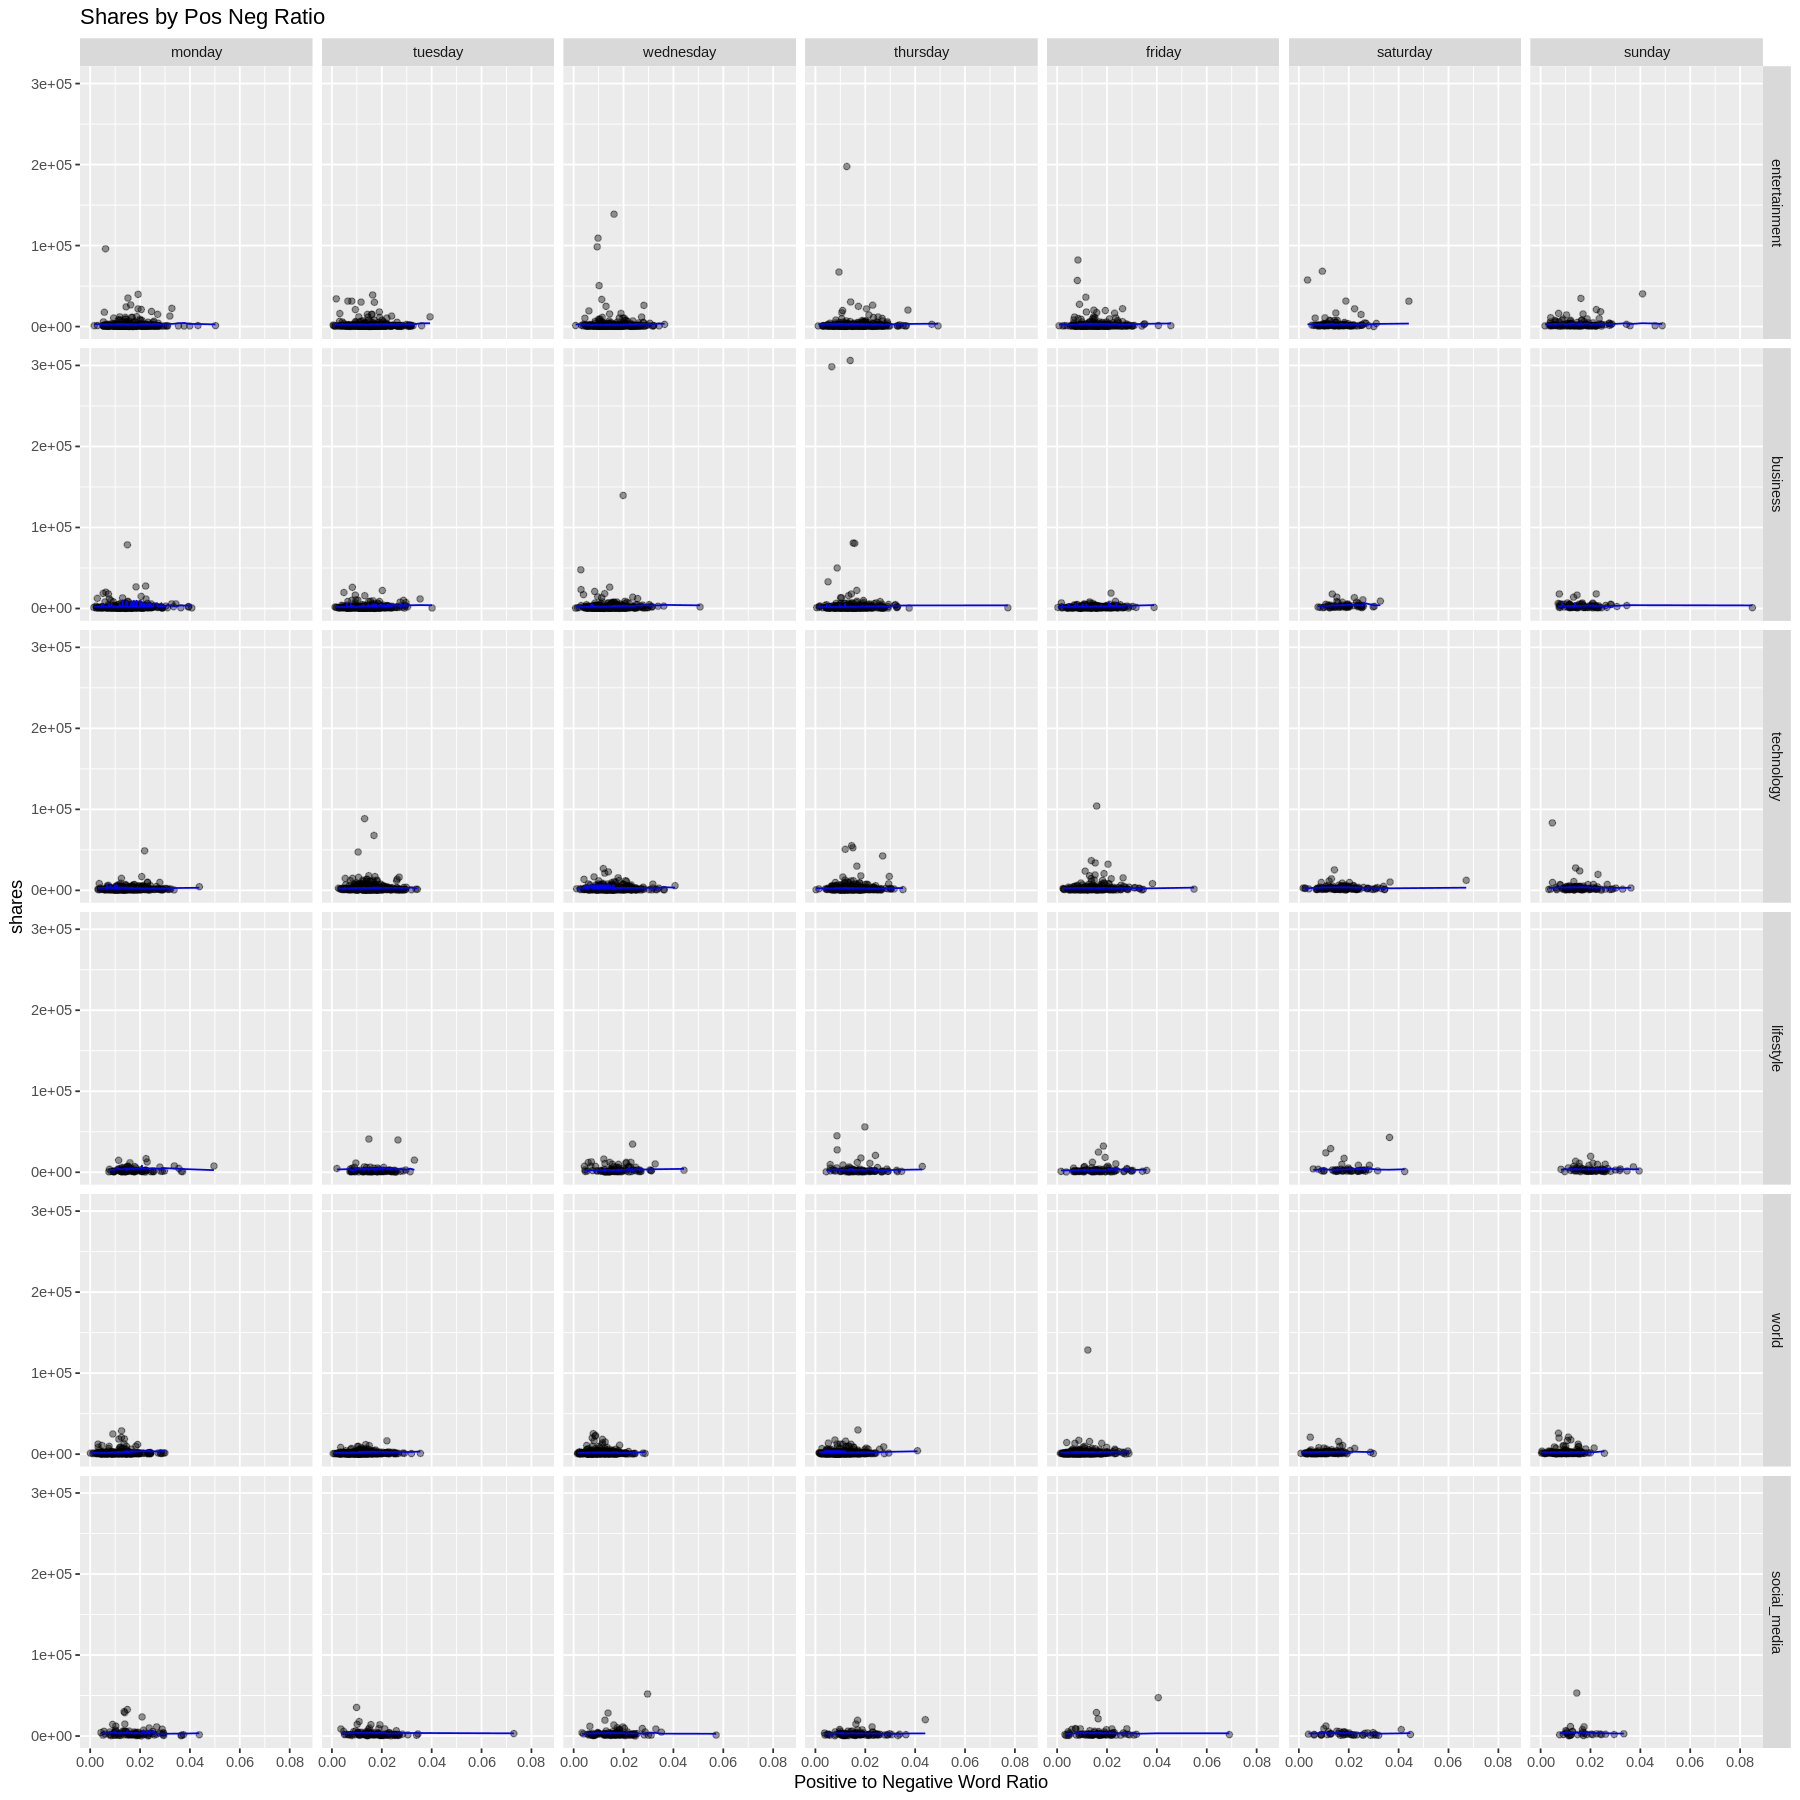

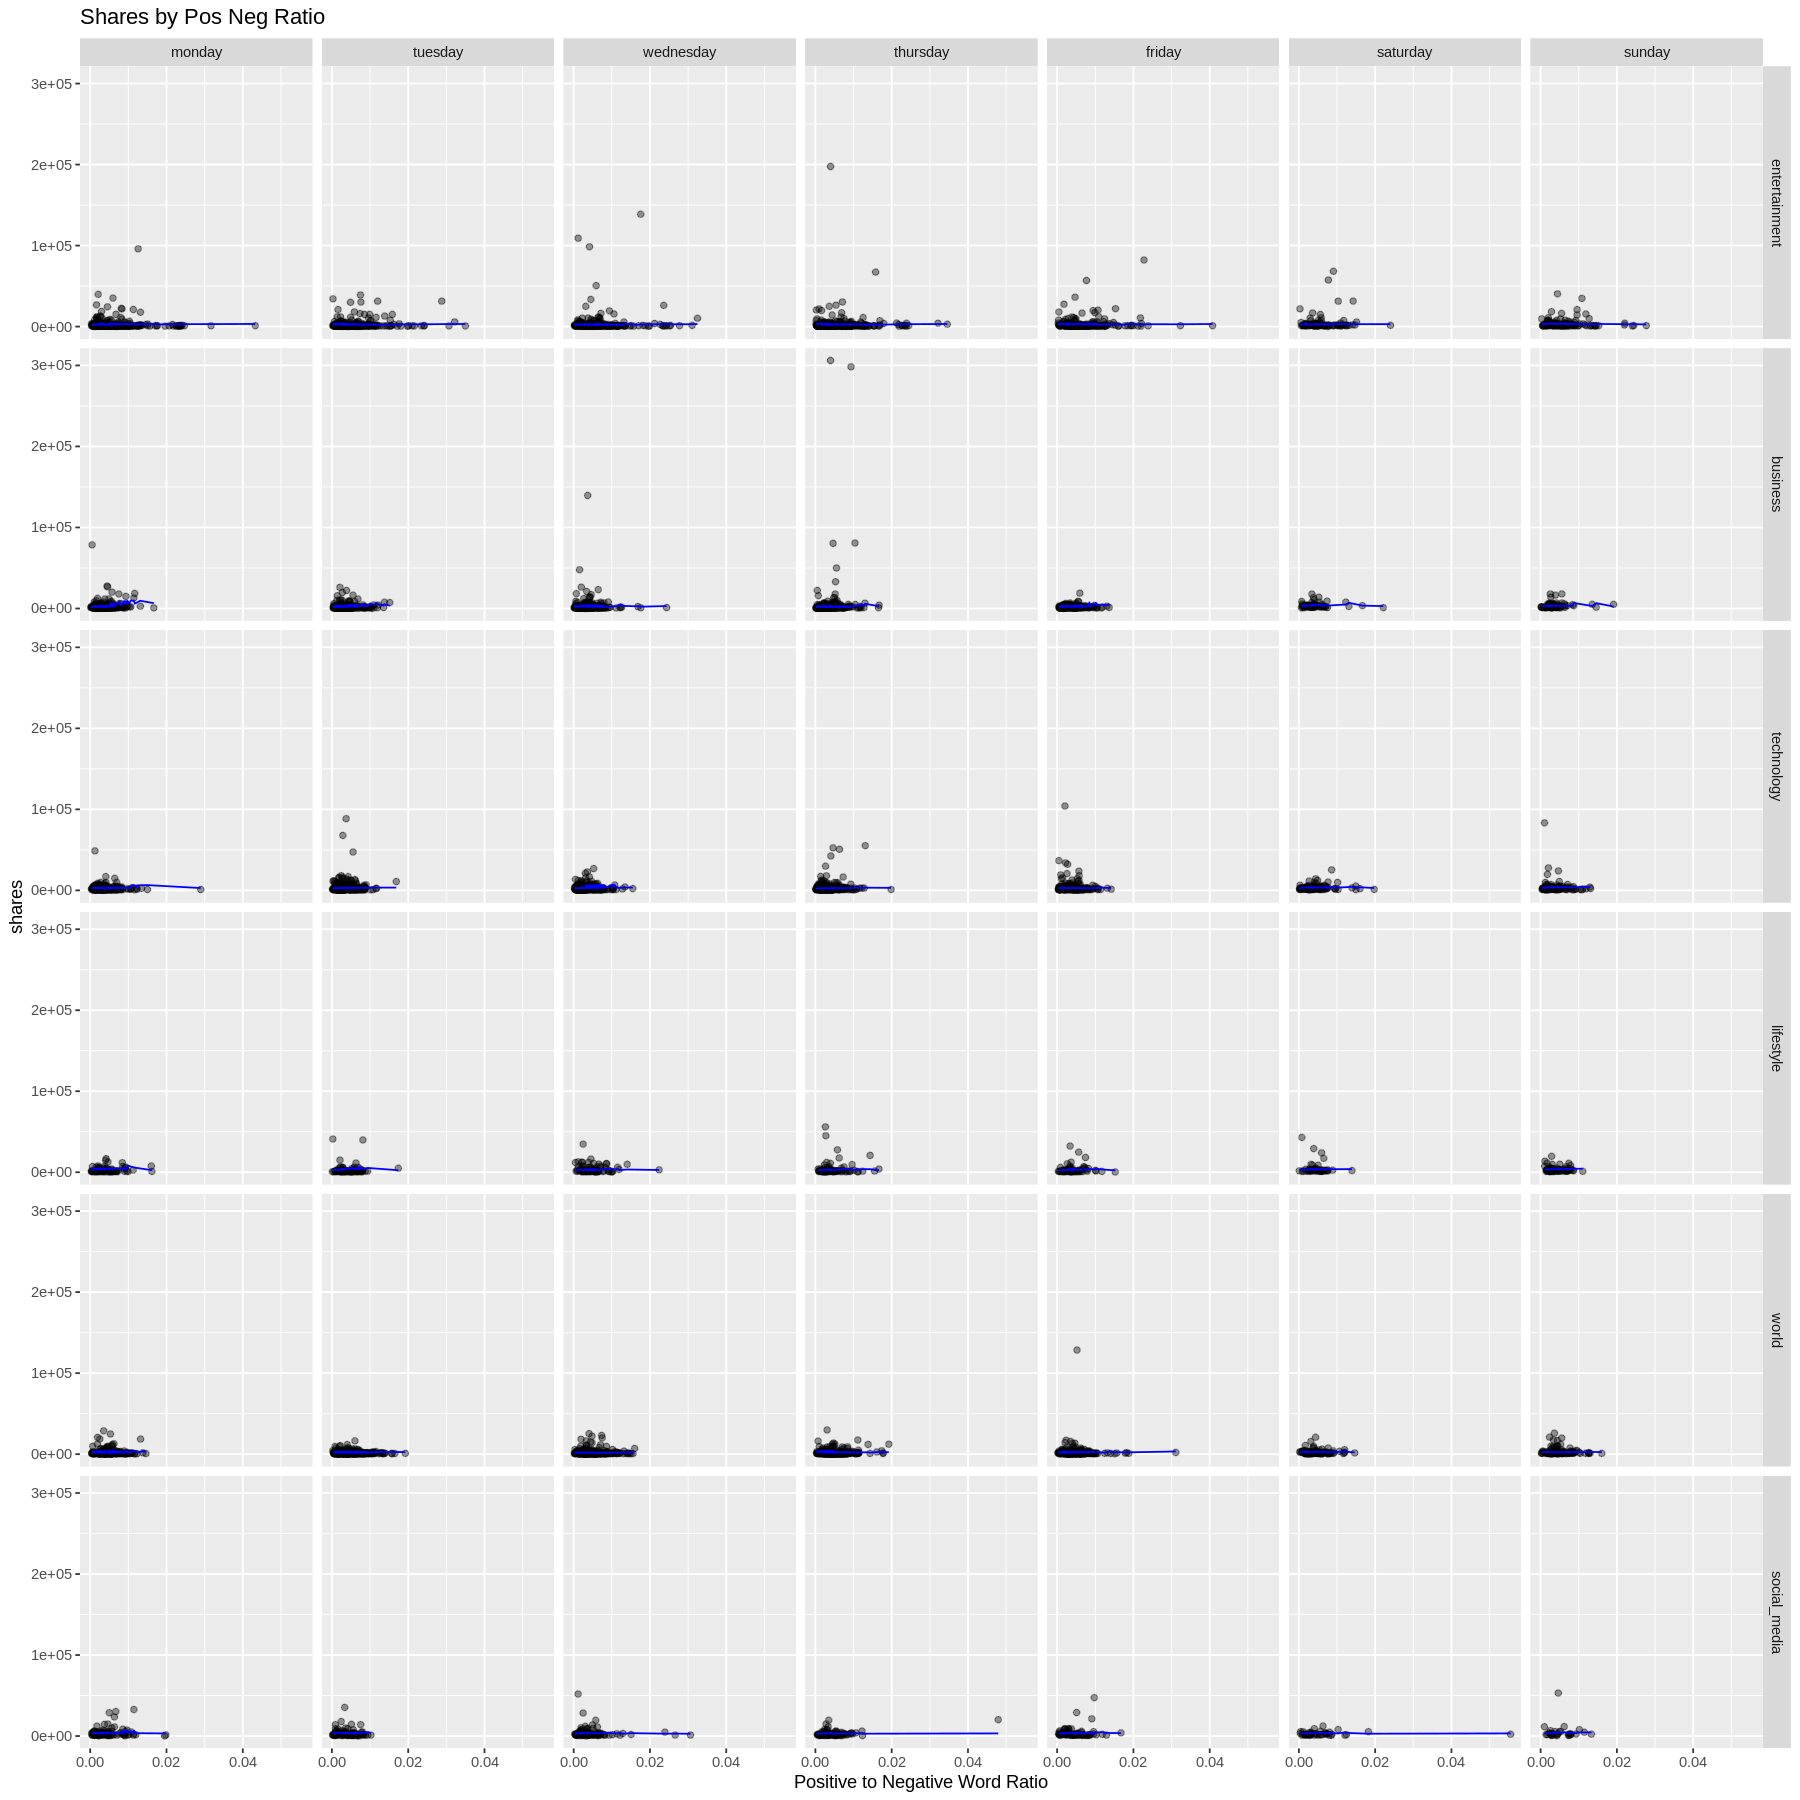

In [40]:
share_plot
share_plot2